In [1]:
import sys
import time
import warnings

#!{sys.executable} -m pip install unidecode

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#pre-processing
import re
import unidecode
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from bs4 import BeautifulSoup

import torch
import torch.nn as nn
from torch.optim.optimizer import Optimizer
import torch.nn.functional as F

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/askani.mohankrishna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/askani.mohankrishna/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import pandas as pd
train_data = pd.read_csv('X_train_twitter.csv')
train_data.head()

,Unnamed: 0,Id,title,time,keywords,data source,country,source URL,body,language
0,3835,1.853845e+09,NaN,2021-04-17 16:23:10+00:00,"['bushfires', 'floods', 'resilience2025', 'ear...",Twitter,NaN,https://twitter.com/minderoo/status/1383372962...,Australia's landscapes need fires to stay heal...,English
1,3213,2.259773e+09,NaN,2021-06-05 22:22:22+00:00,['floods'],Twitter,NaN,https://twitter.com/BruceElke/status/139034872...,@HanmerBrad @VaderstadCanada It is weird seem ...,English
2,2487,2.121309e+07,NaN,2021-12-05 14:45:00+00:00,NaN,Twitter,USA,NaN,New tech coming soon that aims to predict floo...,English
3,3773,1.903037e+07,NaN,2021-04-20 04:30:43+00:00,"['floods', 'flooding']",Twitter,NaN,https://twitter.com/CanadianWater/status/13842...,“Under One Umbrella is a toolbox of practical ...,English
4,3994,3.043044e+08,NaN,2021-11-04 13:33:36+00:00,"['floods', 'timorleste', 'reliefpacks', 'stand...",Twitter,NaN,https://twitter.com/g7plus/status/138115596171...,As part of our relief activities to help the v...,English


In [3]:
train_labels = pd.read_csv('y_train_twitter.csv')
train_labels.head()

,category
0,none
1,none
2,flood
3,flood
4,flood


In [4]:
train_labels['category'].value_counts()

flood    160
none     160
Name: category, dtype: int64

In [5]:
train_data = train_data[['body']]
train_data.head()

,body
0,Australia's landscapes need fires to stay heal...
1,@HanmerBrad @VaderstadCanada It is weird seem ...
2,New tech coming soon that aims to predict floo...
3,“Under One Umbrella is a toolbox of practical ...
4,As part of our relief activities to help the v...


In [6]:
train_labels['category'].value_counts()

flood    160
none     160
Name: category, dtype: int64

In [7]:
import re
from tqdm import tqdm
def preprocess(article):
    """
    This function takes a string as input, then performs these operations: 
        - lowercase
        - remove URLs
        - remove ticker symbols 
        - removes punctuation
        - removes any single character tokens
    Parameters
    ----------
        message : The text message to be preprocessed
    Returns
    -------
        text: The preprocessed text
    """ 
    # Lowercase the article
    text = article.lower()
    # Replace URLs with a space in the message
    text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    text = re.sub('\$[a-zA-Z0-9]*', ' ', text)
    text = re.sub('\@[a-zA-Z0-9]*', ' ', text)
    # Replace everything not a letter or apostrophe with a space
    text = re.sub('[^a-zA-Z\']', ' ', text)
    # Remove single letter words
    text = ' '.join( [w for w in text.split() if len(w)>1] )
    
    return text
        
# Process for all messages
preprocessed = [preprocess(article) for article in tqdm(train_data['body'])]

100%|██████████| 320/320 [00:00<00:00, 31246.85it/s]


In [8]:
preprocessed[0]

"australia's landscapes need fires to stay healthy and to support regeneration new growth increasing severity frequency of bushfires and floods however threatens the delicate balance between positive impact and devastating destruction resilience earthmonth"

In [9]:
from collections import Counter
counts = dict(Counter(word for sentence in preprocessed for word in sentence.split()))
{k: counts[k] for k in list(counts)[:10]}

{"australia's": 1,
 'landscapes': 1,
 'need': 15,
 'fires': 5,
 'to': 208,
 'stay': 1,
 'healthy': 3,
 'and': 206,
 'support': 4,
 'regeneration': 1}

In [10]:
test_data = pd.read_csv('X_test_twitter.csv')

data_test = test_data['body']
data_test = [preprocess(article) for article in tqdm(data_test)]

test_labels = pd.read_csv('y_test_twitter.csv')


100%|██████████| 80/80 [00:00<00:00, 30120.68it/s]


In [44]:
embed_size = 300 # how big is each word vector
max_features = 2000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 500 # max number of words in a content to use

In [45]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(preprocessed)
train_X = tokenizer.texts_to_sequences(preprocessed)
test_X = tokenizer.texts_to_sequences(data_test)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

le = LabelEncoder()
train_y = le.fit_transform(train_labels['category'].values)
test_y = le.transform(test_labels['category'].values)
len(le.classes_)

2

In [46]:
len(tokenizer.word_index)

2830

In [47]:
import pickle
with open("tokenizer_flood_v1.pkl", 'wb') as file:
    pickle.dump(tokenizer, file, protocol=pickle.HIGHEST_PROTOCOL)
with open("label_encoder_flood_v1.pkl", 'wb') as file:
    pickle.dump(le, file, protocol=pickle.HIGHEST_PROTOCOL)

In [48]:
EMBEDDING_FILE = 'glove.840B.300d.txt'
debug = 0
def load_glove(word_index):
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    del embeddings_index['PN']
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

if debug:
    embedding_matrix = np.random.randn(max_features,embed_size)
else:
    embedding_matrix = load_glove(tokenizer.word_index)
np.shape(embedding_matrix)

/Users/askani.mohankrishna/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


(2000, 300)

In [49]:
import numpy as np
np.save('embedding_matrix_flood_v1.npy' , embedding_matrix)

In [50]:
train_X1 = train_X[:2]

#Paste num in self.extra_features below 
train_X1.shape[1] - maxlen

0

In [51]:
class BiLSTM(nn.Module): 
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size_1 = 64
        self.hidden_size_2 = 64
        self.extra_features = 0
        drp = 0.1
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size_1, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size_1*4 + self.extra_features, self.hidden_size_2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(self.hidden_size_2, n_classes)

    def forward(self, x):
        input = x[:,:maxlen]
        of = x[:,maxlen:]
        
        h_embedding = self.embedding(input)
        
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool, of), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [64]:
n_epochs = 8
batch_size = 20


model = BiLSTM()

loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long)#.cuda()
y_train = torch.tensor(train_y, dtype=torch.long)#.cuda()

x_cv = torch.tensor(test_X, dtype=torch.long)#.cuda()
y_cv = torch.tensor(test_y, dtype=torch.long)#.cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] = F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))


<ipython-input-64-e3898804d620>:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] = F.softmax(y_pred).cpu().numpy()


Epoch 1/8 	 loss=13.9989 	 val_loss=13.7288  	 val_acc=0.5000  	 time=6.05s
Epoch 2/8 	 loss=13.6960 	 val_loss=13.2153  	 val_acc=0.7375  	 time=5.85s
Epoch 3/8 	 loss=12.8206 	 val_loss=12.0676  	 val_acc=0.7625  	 time=5.87s
Epoch 4/8 	 loss=10.4307 	 val_loss=12.1708  	 val_acc=0.7000  	 time=5.85s
Epoch 5/8 	 loss=8.4037 	 val_loss=10.3961  	 val_acc=0.7250  	 time=5.81s
Epoch 6/8 	 loss=7.1250 	 val_loss=9.5453  	 val_acc=0.7500  	 time=5.79s
Epoch 7/8 	 loss=5.3007 	 val_loss=9.8073  	 val_acc=0.8000  	 time=5.80s
Epoch 8/8 	 loss=3.6183 	 val_loss=9.9324  	 val_acc=0.8250  	 time=5.83s


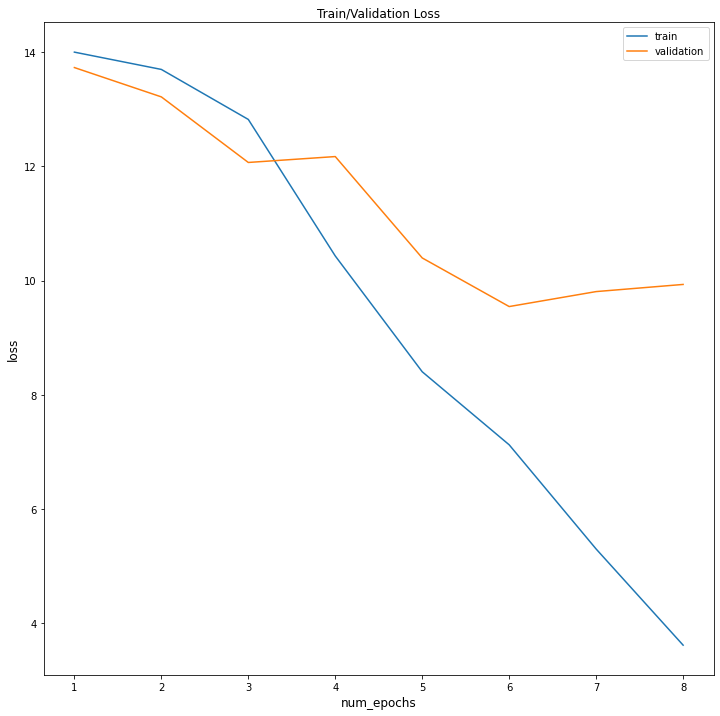

In [65]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
plot_graph(n_epochs)

In [66]:
pred = le.inverse_transform(val_preds.argmax(axis=1))
test = le.inverse_transform(test_y)
from sklearn.metrics import classification_report
print(classification_report(test,pred,labels=train_labels['category'].unique()))

              precision    recall  f1-score   support

        none       0.81      0.85      0.83        40
       flood       0.84      0.80      0.82        40

    accuracy                           0.82        80
   macro avg       0.83      0.82      0.82        80
weighted avg       0.83      0.82      0.82        80



In [67]:
filename = 'model_twitter_flood_v1.pt'
torch.save(model.state_dict(), filename)